In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
import torch
from torch.utils import data

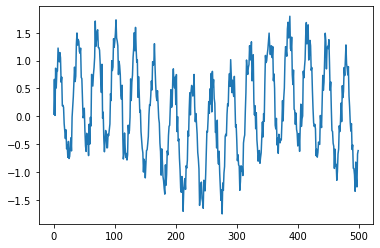

In [27]:
TIME_LAGS = 10
BATCH_SIZE = 32
EPOCH = 5

n_samples = 5000
time = np.linspace(0,1000, n_samples)
X = np.sin(time) + np.random.normal(0,0.2, n_samples) + 0.5 * np.sin(time/10)

plt.plot(X[0:500])

In [28]:
class TimeSeriesDataset(data.Dataset):
    
    def __init__(self, X, y, time_lags):
        self.X = X
        self.y = y
        self.time_lags = time_lags

    def __len__(self):
        return len(self.X) - self.time_lags

    def __getitem__(self, idx):
        shifted_idx = idx + self.time_lags
        return np.reshape(self.X[idx:shifted_idx], (self.time_lags, -1)), self.y[shifted_idx]

In [29]:
dataset = TimeSeriesDataset(X, X, TIME_LAGS)
dataloader = data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

In [40]:
class CNN1D(nn.Module):
    """Very simple implementation of 1D-CNN time-series classifier."""
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv1d(in_channels=1, out_channels=32, 
                                             kernel_size=2), nn.ReLU()) # Out shape is (batch_size, out_channels, 8)
        self.fc = nn.Linear(288, 10)
        self.fc2 = nn.Linear(10,1)
    
    def forward(self, x):
        x = self.conv1(x)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        print(np.shape(x))
        x = self.fc(x)
        out = self.fc2(x)
        return out

In [44]:
cnn = CNN1D().double()
print(cnn)  # net architecture

optimizer = torch.optim.Adam(cnn.parameters(), lr=0.01)   # optimize all cnn parameters
loss_func = nn.MSELoss()                       # the target label is not one-hotted

CNN1D(
  (conv1): Sequential(
    (0): Conv1d(1, 32, kernel_size=(2,), stride=(1,))
    (1): ReLU()
  )
  (fc): Linear(in_features=288, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=1, bias=True)
)


In [48]:
# training and testing
for epoch in range(EPOCH):
    for step, (b_x, b_y) in enumerate(dataloader):   # gives batch data, normalize x when iterate train_loader
        
        output = cnn(b_x.reshape(32, 1, -1).double())[0]
        loss = loss_func(output, b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % 50 == 0:
            test_output = cnn(b_x.reshape(32, 1, -1).double())
            pred_y = torch.max(output)[0].data.numpy()
            accuracy = float((pred_y == test_y.data.numpy()).astype(int).sum()) / float(test_y.size(0))
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)

torch.Size([32, 288])
torch.Size([32, 288])


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)